In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image 
from tensorflow.keras.utils import load_img
import pathlib
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
from tensorflow.keras import regularizers
import sys
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense

C:\Users\janma\.conda\envs\py_tf_gpu\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Creating custom data generator class 

In [2]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self,df,x_col,y_col,batch_size,path,input_size,shuffle=True,):
        self.df = df.copy()
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.path = path
        self.shuffle = shuffle

        self.n = len(self.df)
        self.n_age = df[y_col['Age']].nunique()
        self.n_gender = df[y_col['Gender']].nunique()
        self.n_race = df[y_col['Race']].nunique()

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __get_input(self,x,size):
        img = Image.open(os.path.join(self.path, x))
        img = img.resize((size[0],size[1]))
        img = img.convert('RGB')
        return np.array(img,dtype=np.float32) / 255 


    def __get_data(self,batches):
        images_batch = batches[self.x_col]
        age_batch = batches[self.y_col['Age']]
        gender_batch = batches[self.y_col['Gender']]
        race_batch = batches[self.y_col['Race']]

        X_batch = np.asarray([self.__get_input(x,self.input_size) for x in images_batch])

        y0_batch = np.asarray([int(x) for x in race_batch])
        y1_batch = np.asarray([int(x) for x in gender_batch])
        y2_batch = np.asarray([int(x) for x in age_batch])

        return X_batch,[y0_batch,y1_batch,y2_batch]


    def __getitem__(self,index):
        batches = self.df[index*self.batch_size:(index+1)*self.batch_size]
        X,y = self.__get_data(batches)
        return X,y

    def __len__(self):
        return self.n // self.batch_size


In [3]:
dataset_path_age_as_number = './Dataset'
dataset_path_age_as_range = './Dataset_changed_age'

In [4]:
img_height = 224
img_width = 224
race = np.array(['White','Black','Asian','Indian','Others'])
gender = np.array(['Male','Female'])
age = np.array(['[0-9]','[10-19]','[20-29]','[30-39]','[40-49]','[50-59]','[60-69]','[70-79]','[80-89]','[90-99]'])

gender_map = {
    0: "Male",
    1: "Female"
}

race_map = {
    0 : 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Other',
}

age_map = {
    0 : '[0-9]', 
    1 : '[10-19]',
    2 : '[20-29]',
    3 : '[30-39]',
    4 : '[40-49]',
    5 : '[50-59]', 
    6 : '[60-69]',
    7 : '[70-79]',
    8 : '[80-89]', 
    9 : '[90-99]', 
}


# Creating DataFrame with all images

In [5]:
import random
image_filenames = np.array(os.listdir(dataset_path_age_as_range),dtype=np.str_)
random.shuffle(image_filenames)

In [6]:
def extract_features(filename):
    age,gender,race,_ = filename.split('_')
    return (int(age),int(gender),int(race),filename)


In [7]:
feature = np.array([extract_features(filename) for filename in image_filenames])
df = pd.DataFrame(feature, columns=['Age','Gender','Race','Image'])
df.head()



,Age,Gender,Race,Image
0,2,0,3,2_0_3_20161220221833874.jpg
1,5,0,3,5_0_3_20170119204549750.jpg
2,3,0,3,3_0_3_20170119144131781.jpg
3,2,1,1,2_1_1_20170116232709732.jpg
4,5,0,3,5_0_3_20170119180731484.jpg


### Number of images

In [8]:
print(len(df))

17416


In [9]:
df.describe(include='all')

,Age,Gender,Race,Image
count,17416,17416,17416,17416
unique,10,2,5,17416
top,2,0,0,2_0_3_20161220221833874.jpg
freq,6603,9128,5656,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17416 entries, 0 to 17415
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     17416 non-null  object
 1   Gender  17416 non-null  object
 2   Race    17416 non-null  object
 3   Image   17416 non-null  object
dtypes: object(4)
memory usage: 544.4+ KB


# Explorary data analysis

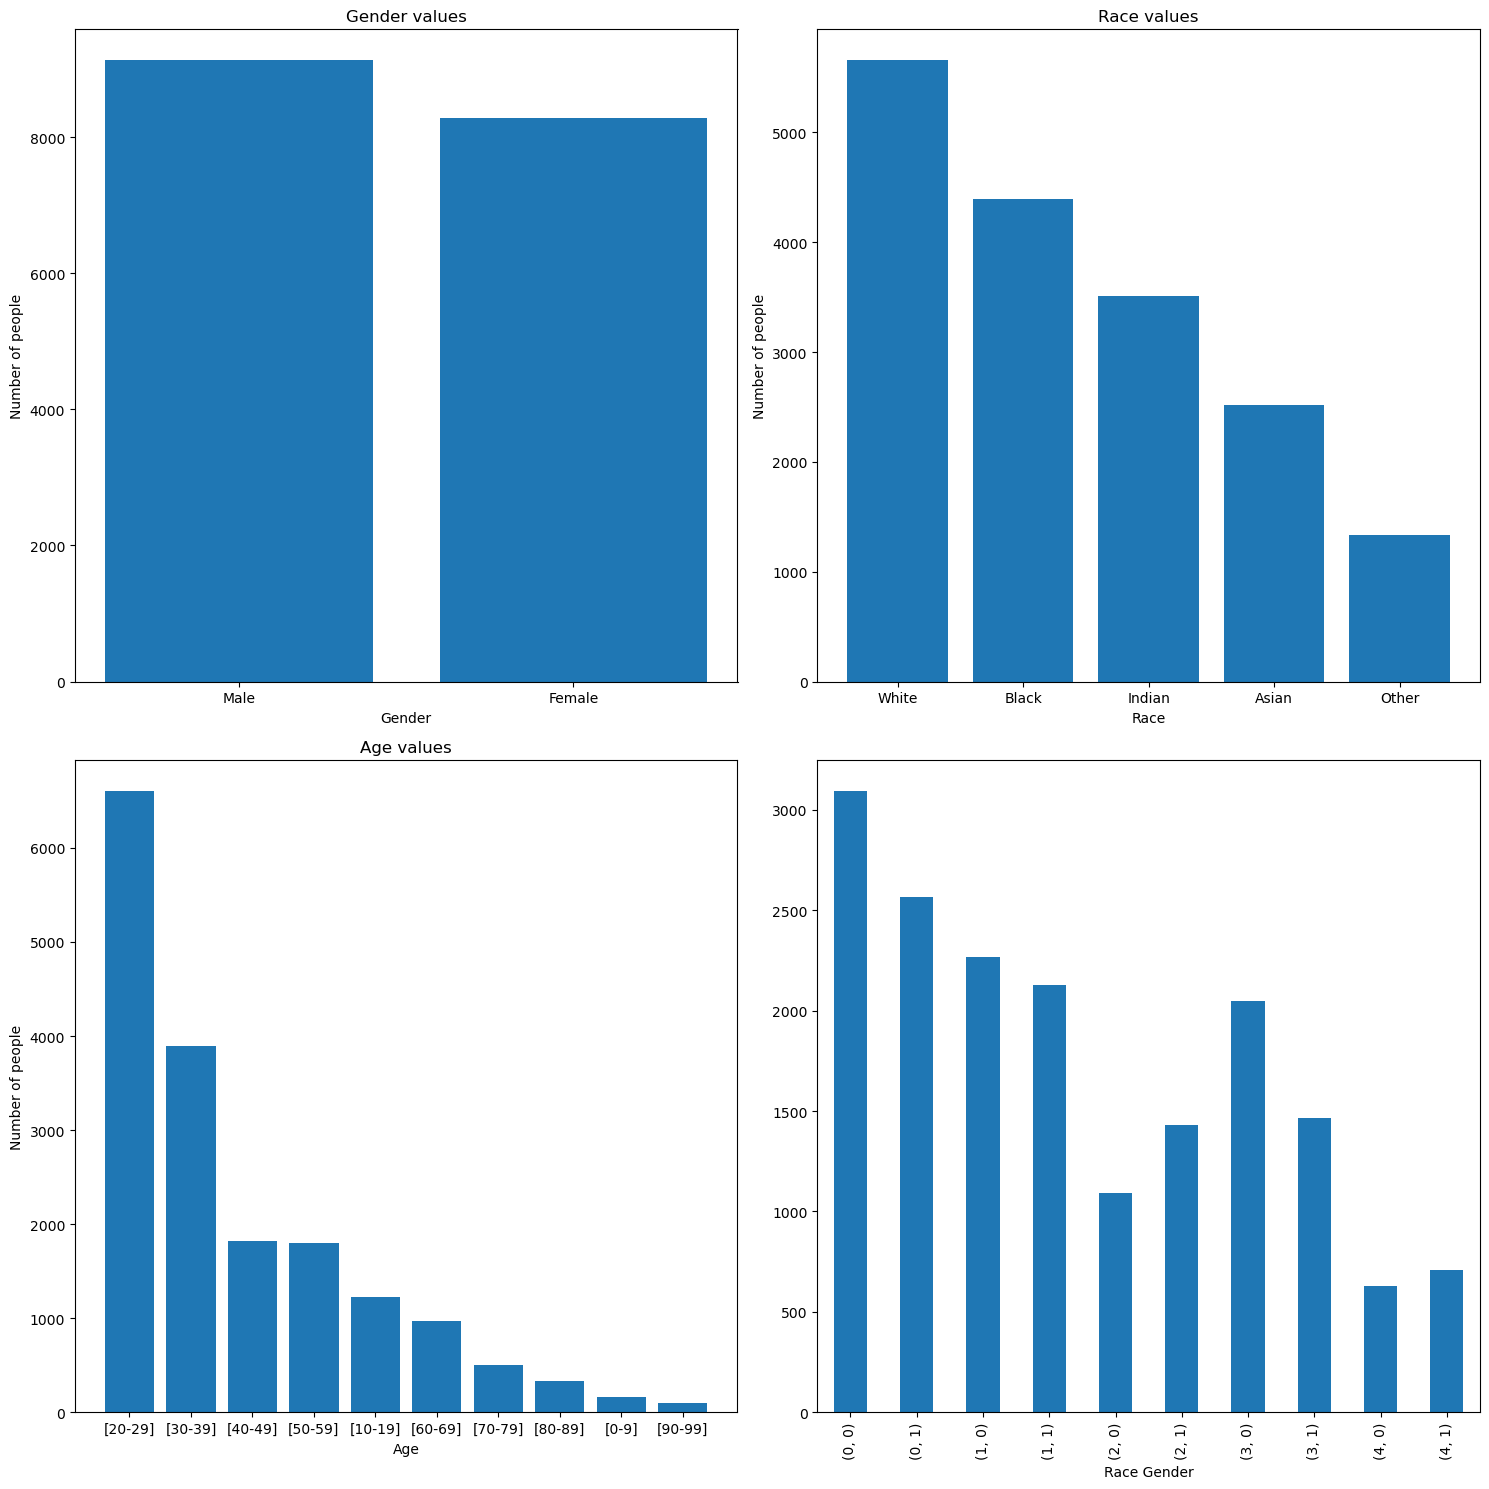

In [11]:
gender_counts = df['Gender'].value_counts()
race_counts = df['Race'].value_counts()
age_counts = df['Age'].value_counts()

fig, axs = plt.subplots(2, 2, figsize=(15, 15))  


axs[0][0].bar(gender_counts.index.astype(int).map(gender_map), gender_counts.values)
axs[0][0].set_title('Gender values')
axs[0][0].set_xlabel('Gender')
axs[0][0].set_ylabel('Number of people')

axs[0][1].bar(race_counts.index.astype(int).map(race_map), race_counts.values)
axs[0][1].set_title('Race values')
axs[0][1].set_xlabel('Race')
axs[0][1].set_ylabel('Number of people')

axs[1][0].bar(age_counts.index.astype(int).map(age_map),age_counts.values)
axs[1][0].set_title('Age values')
axs[1][0].set_xlabel('Age')
axs[1][0].set_ylabel('Number of people')

axs[1][1] = df.groupby(by=['Race','Gender'])[['Race','Gender']].value_counts().plot(kind='bar')
axs[1][1].set_xlabel('Race Gender')

plt.tight_layout()  
plt.show()

## Few example images

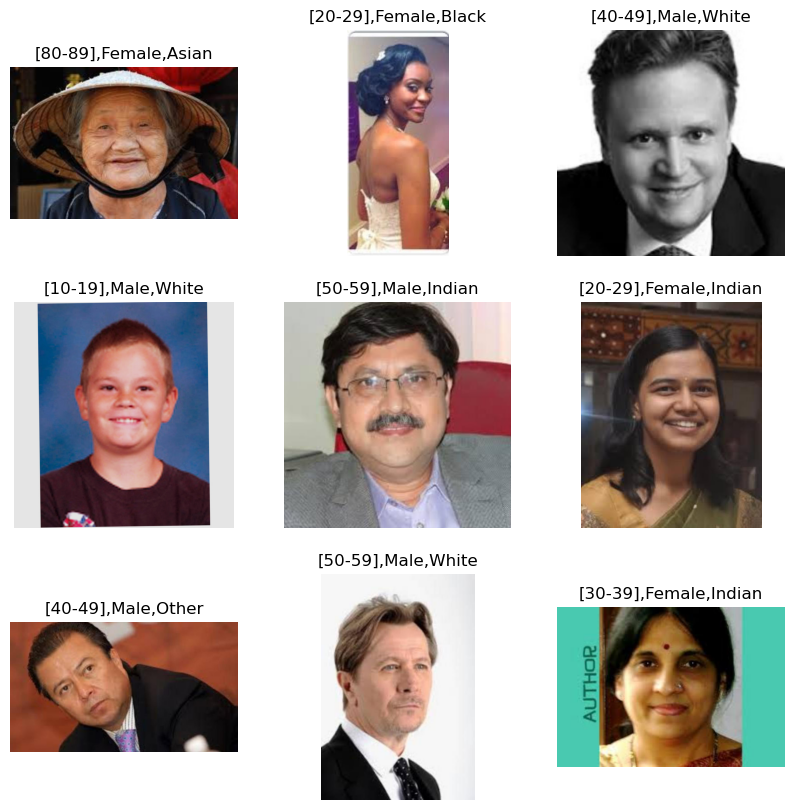

In [12]:
plt.figure(figsize=(10,10))
for i in range(9):
    random_index = random.randint(0,len(df))
    ax = plt.subplot(3,3,i+1)
    df_row = df.iloc[random_index]
    img = Image.open(os.path.join(dataset_path_age_as_range,df_row['Image']))
    plt.title(f"{age_map[int(df_row['Age'])]},{gender_map[int(df_row['Gender'])]},{race_map[int(df_row['Race'])]}")
    plt.axis('off')
    plt.imshow(img)

# Data pre-processing


### Spliting data to training, validation and  testing set

In [13]:
from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(df,test_size=0.006,random_state=42)
df_train,df_valid = train_test_split(df_train,test_size=0.15,random_state=42)
print(len(df_train))
print(len(df_test))
print(len(df_valid))



14714
105
2597


## Creating training and validation data as batch [64] from class CustomDataGen()

In [14]:
traingen = CustomDataGen(df_train,
                         x_col='Image',
                         y_col={'Age': 'Age', 'Race': 'Race','Gender':'Gender'},
                         batch_size=32, path=dataset_path_age_as_range,input_size=(img_width,img_height,3))

valgen = CustomDataGen(df_valid,
                       x_col='Image',
                       y_col={'Age': 'Age', 'Race': 'Race','Gender':'Gender'},
                       batch_size=32, path=dataset_path_age_as_range,input_size=(img_width,img_height,3))

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [15]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

# Creating a CNN model

In [18]:

inputs = tf.keras.layers.Input((img_width,img_height,3))
x = data_augmentation(inputs)
x = Conv2D(96, kernel_size=(5,5), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(5, 5), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(160, kernel_size=(5, 5), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(192, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(228, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(260, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

race_output = tf.keras.layers.Dense(len(race), activation='linear',name='race_output')(x)
gender_output = tf.keras.layers.Dense(1, activation='linear',name='gender_output')(x)
age_output = tf.keras.layers.Dense(len(age), activation='linear',name='age_output')(x)

model = tf.keras.models.Model(inputs=inputs,outputs=[race_output,gender_output,age_output]) 

model.compile(optimizer='adam',
              loss = {
                  "race_output" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  "gender_output" : tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  "age_output" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              },
              metrics={
                  "race_output" : 'accuracy',
                  "gender_output" : 'accuracy',
                  "age_output" : 'accuracy'
              })

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 220, 220, 96  7296        ['sequential[2][0]']             
                                )                                                                 
                                                                                            

# Training

In [52]:
from keras.models import load_model
model_pretrained = load_model("model.h5")

In [53]:
model_pretrained.compile(optimizer='adam',
              loss = {
                  "race_output" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  "gender_output" : tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  "age_output" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              },
              metrics={
                  "race_output" : 'accuracy',
                  "gender_output" : 'accuracy',
                  "age_output" : 'accuracy'
              })

In [54]:
epochs = 10

In [55]:

history = model_pretrained.fit(traingen,
                   epochs=epochs,
                   validation_data=valgen,
                   callbacks=[early_stopping,checkpoint],
                   )



Epoch 1/10
459/459 [==============================] - ETA: 0s - loss: 3.1212 - race_output_loss: 1.1499 - gender_output_loss: 0.3812 - age_output_loss: 1.5900 - race_output_accuracy: 0.5656 - gender_output_accuracy: 0.8207 - age_output_accuracy: 0.4131
Epoch 1: val_loss improved from 3.00272 to 2.99667, saving model to model.h5
459/459 [==============================] - 2574s 6s/step - loss: 3.1212 - race_output_loss: 1.1499 - gender_output_loss: 0.3812 - age_output_loss: 1.5900 - race_output_accuracy: 0.5656 - gender_output_accuracy: 0.8207 - age_output_accuracy: 0.4131 - val_loss: 2.9967 - val_race_output_loss: 1.1189 - val_gender_output_loss: 0.3322 - val_age_output_loss: 1.5456 - val_race_output_accuracy: 0.5818 - val_gender_output_accuracy: 0.8511 - val_age_output_accuracy: 0.4217
Epoch 2/10
459/459 [==============================] - ETA: 0s - loss: 3.0915 - race_output_loss: 1.1391 - gender_output_loss: 0.3726 - age_output_loss: 1.5798 - race_output_accuracy: 0.5706 - gender_outp

# Plotting the results

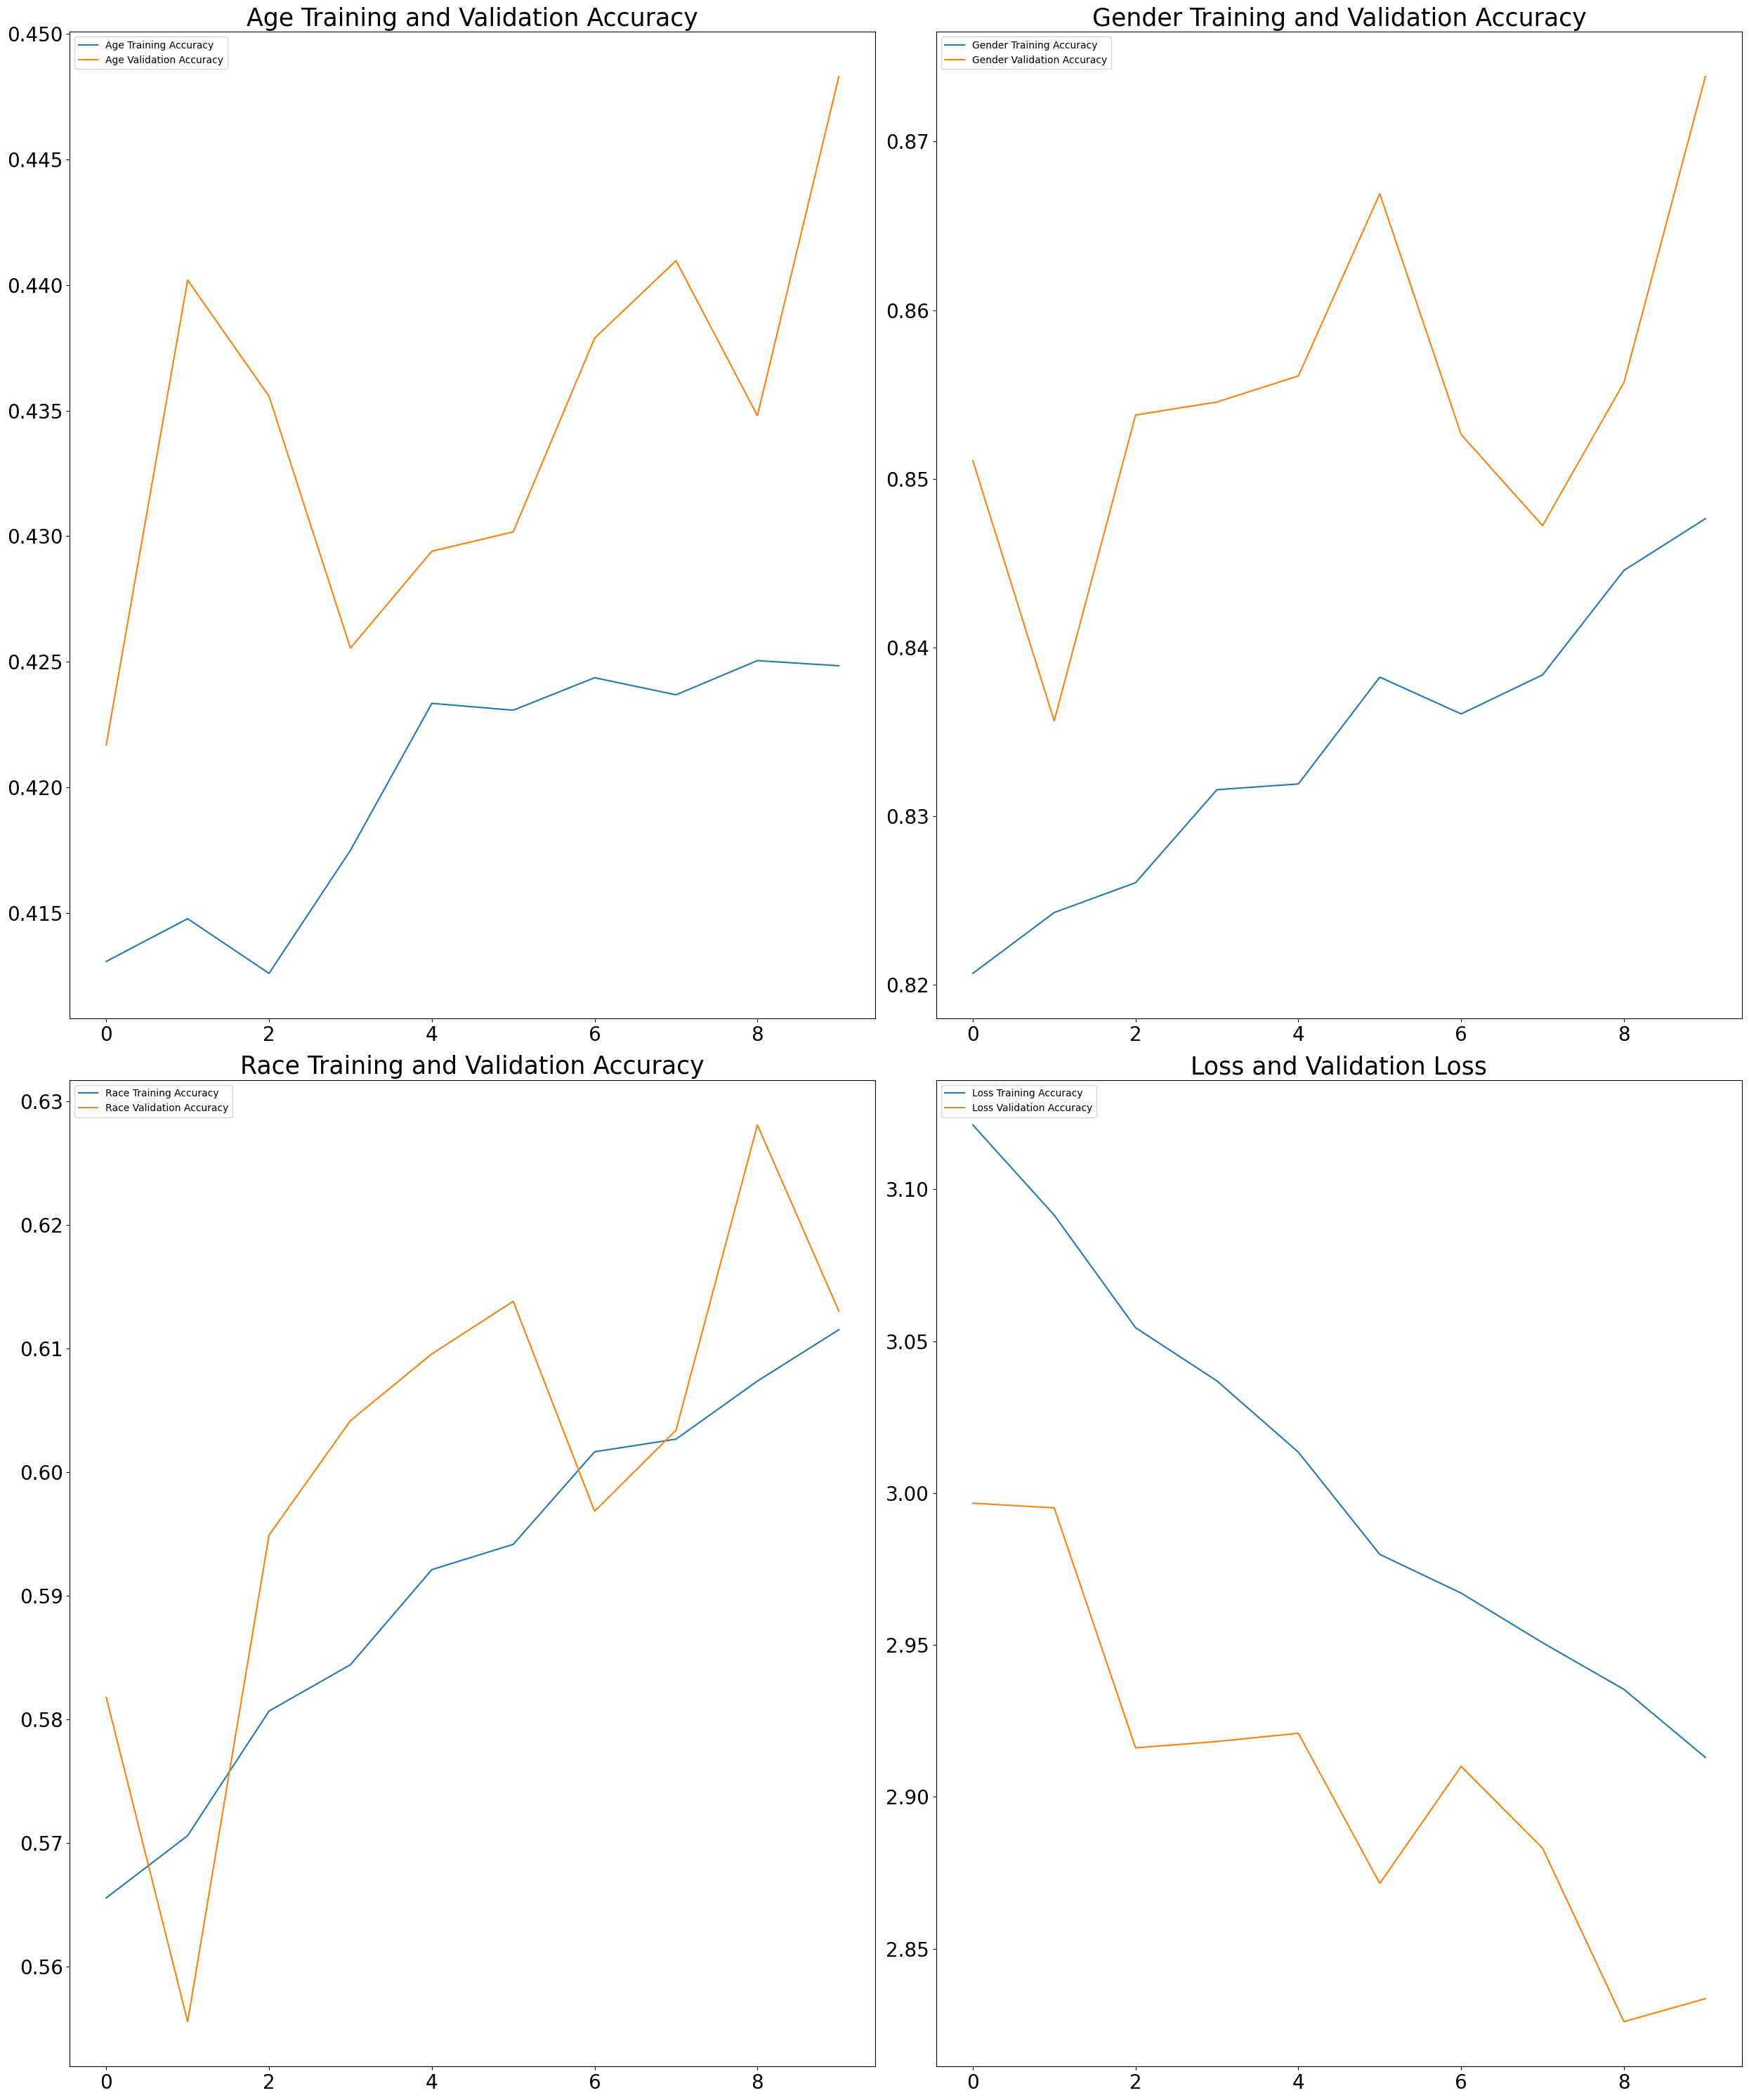

In [56]:

age_acc = history.history['age_output_accuracy']
age_val_acc = history.history['val_age_output_accuracy']

gender_acc = history.history['gender_output_accuracy']
gender_val_acc = history.history['val_gender_output_accuracy']

race_acc = history.history['race_output_accuracy']
race_val_acc = history.history['val_race_output_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)


fig, axs = plt.subplots(2, 2, figsize=(25, 30))


axs[0][0].plot(epochs_range, age_acc, label='Age Training Accuracy')
axs[0][0].plot(epochs_range, age_val_acc, label='Age Validation Accuracy')
axs[0][0].legend(loc='upper left')
axs[0][0].set_title('Age Training and Validation Accuracy',size=25)
axs[0][0].tick_params(axis='both', which='major', labelsize=20)  


axs[0][1].plot(epochs_range, gender_acc, label='Gender Training Accuracy')
axs[0][1].plot(epochs_range, gender_val_acc, label='Gender Validation Accuracy')
axs[0][1].legend(loc='upper left')
axs[0][1].set_title('Gender Training and Validation Accuracy',size=25)
axs[0][1].tick_params(axis='both', which='major', labelsize=20)  


axs[1][0].plot(epochs_range, race_acc, label='Race Training Accuracy')
axs[1][0].plot(epochs_range, race_val_acc, label='Race Validation Accuracy')
axs[1][0].legend(loc='upper left')
axs[1][0].set_title('Race Training and Validation Accuracy',size=25)
axs[1][0].tick_params(axis='both', which='major', labelsize=20)  

axs[1][1].plot(epochs_range, loss, label='Loss Training Accuracy')
axs[1][1].plot(epochs_range, val_loss, label='Loss Validation Accuracy')
axs[1][1].legend(loc='upper left')
axs[1][1].set_title('Loss and Validation Loss',size=25)
axs[1][1].tick_params(axis='both', which='major', labelsize=20) 

plt.tight_layout()
plt.show()



# Predictions

In [25]:
model.save('model.h5')

In [31]:
from keras.models import load_model
model_preloaded = load_model("model.h5")

In [32]:
def predict(img):
    img_array = img.convert('RGB')
    img_array = np.array(img_array) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    race_pred, gender_pred, age_pred = model_preloaded.predict(img_array)
    return tf.nn.softmax(race_pred),tf.nn.sigmoid(gender_pred), tf.nn.softmax(age_pred)

1/1 [==============================] - 0s 52ms/step


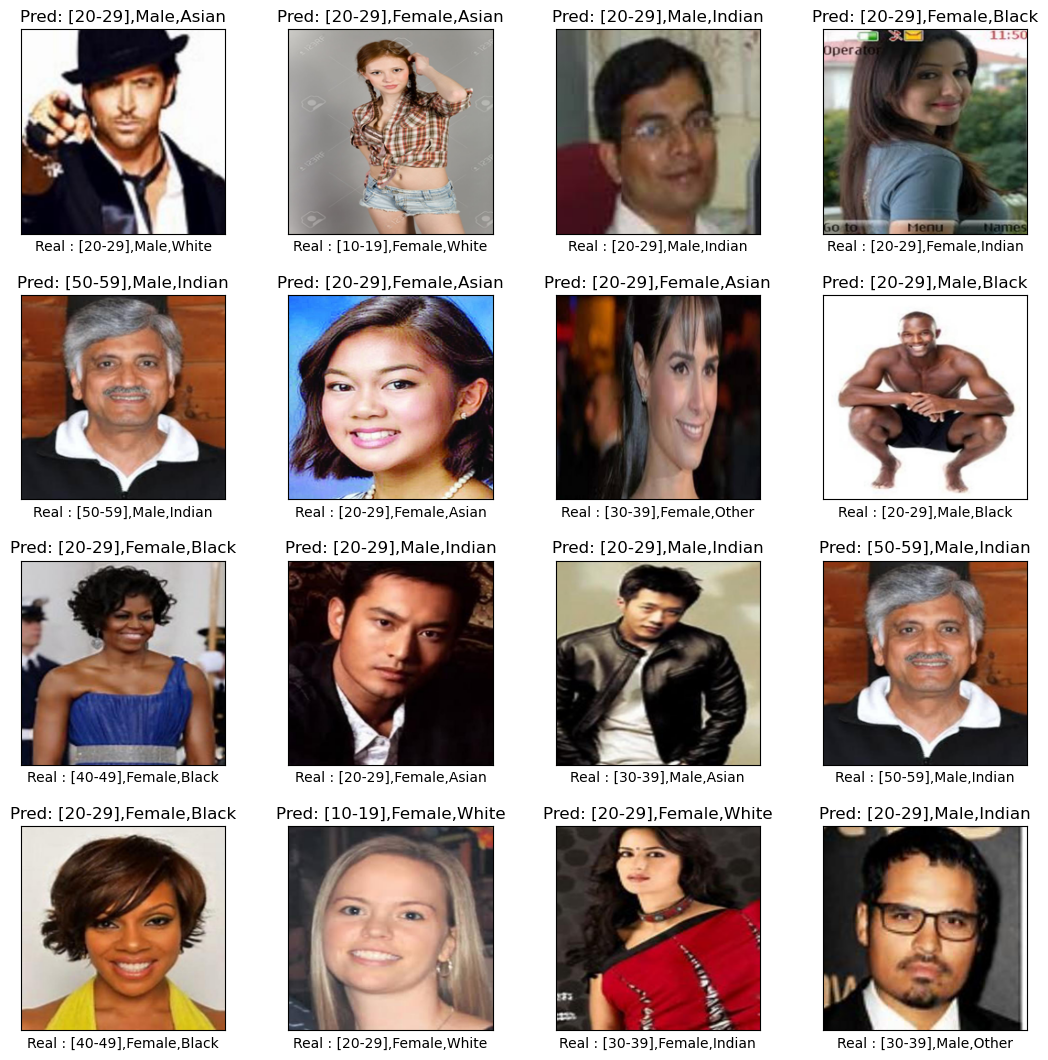

In [50]:
plt.figure(figsize=(13,13))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(16):
    random_index = random.randint(0,len(df_test)-1)
    ax = plt.subplot(4,4,i+1)
    df_row = df_test.iloc[random_index]
    img = Image.open(os.path.join(dataset_path_age_as_range,df_row['Image']))
    img_array = img.resize((img_width,img_height))
    plt.imshow(img_array)
    race_pred,gender_pred,age_pred = predict(img_array)
    plt.xlabel(f"Real : {age_map[int(df_row['Age'])]},{gender_map[int(df_row['Gender'])]},{race_map[int(df_row['Race'])]}")
    plt.title(f"Pred: {age_map[age_pred.numpy().argmax()]},{gender_map[gender_pred.numpy()[0,0] > 0.5]},{race_map[race_pred.numpy().argmax()]}")
    plt.xticks([])
    plt.yticks([])
    